In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.style.use('dark_background')

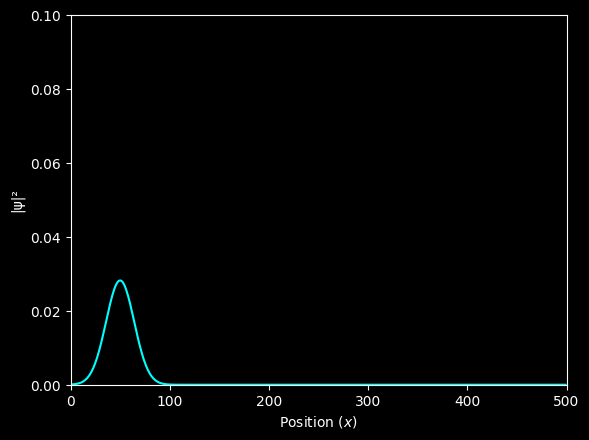

In [2]:
#parameters
L=500
x0=50
hbar=1
k0=0.9
dt=0.01 
sigma=20
frames=100000 
x = np.arange(L)
dx=1 #spacing between consecutive points of x

#initial wave function
psi0 = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x-x0))
a=np.sum(np.abs(psi0)**2*dx) 
psi0 /= np.sqrt(a)

#array to store wave func @ next time step
psi=psi0.copy() #same values as psi0 but independent of each other - represent the current psi
psi_next=np.zeros(L, dtype=complex) #create array (0) w/ shape L to be filled by new psi values

#plot
fig, ax = plt.subplots()
ax.set_xlim(0, L)
ax.set_ylim(0, 0.1)
ax.set_xlabel(r"Position $(x)$")
ax.set_ylabel("|ψ|²")
line, = ax.plot(x, np.abs(psi0)**2, color="cyan")

In [3]:
x_c_list = []  #store x_c values
time_list = [] #store corresponding time values
velocity_list = []
ani=animation.FFMpegWriter(fps=100, bitrate=1800)
with ani.saving(fig, "Weyl_wavepacket_EFDM.mp4", dpi=100):
    for frame in range(frames):
        x_c = np.sum(x * np.abs(psi)**2) / np.sum(np.abs(psi)**2) #center position x_c of the packet
        t=2*x_c/L #spatially varying tilt
        x_c_list.append(x_c)
        time_list.append(frame * dt)

        dpsi_dx=np.zeros(L, dtype=complex) #1st derivative entral difference
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx) #vectorized way to compute the central difference
        
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)  #left boundary
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  #right boundary

        d3psi_dx3 = np.zeros_like(psi)  #array for 3rd derivative
        d3psi_dx3[2:-2]= (psi[4:] - 2*psi[3:-1] + 2*psi[1:-3] - psi[:-4]) / (2*dx**3) #3rd derivative interior points
        
        #3rd derivative central difference w/ periodic bc
        d3psi_dx3[0] = (psi[2] - 2 * psi[1] + 2 * psi[-1] - psi[-2]) / (2 * dx**3)  #left boundary
        d3psi_dx3[1] = (psi[3] - 2 * psi[2] + 2 * psi[0] - psi[-1]) / (2 * dx**3)  #2nd point
        d3psi_dx3[-1] = (psi[1] - 2 * psi[0] + 2 * psi[-2] - psi[-3]) / (2 * dx**3)  #right boundary
        d3psi_dx3[-2] = (psi[0] - 2 * psi[-1] + 2 * psi[-3] - psi[-4]) / (2 * dx**3)  #2nd to last point

        #psi_next=(psi-(1j/hbar)*dt*((1-t)*(-1j*hbar*dpsi_dx))) #energy dispersion 1st model
        psi_next=psi-(1j/hbar)*dt*((1-t)*(-1j*hbar*dpsi_dx) - (-1j*hbar**3 * d3psi_dx3) / 8) #energy dispersion 2nd model
        
        #periodic b.c
        psi_next[0] = psi_next[-1] #derivative is 0 at left boundary
        psi_next[-1] = psi_next[0] #derivative is 0 at right boundary
        
        psi_next /= np.sqrt(np.sum(np.abs(psi_next)**2 * dx)) #maintain total probability packet = 1
        psi=psi_next.copy() #update current psi after values calculated in psi_next 

        line.set_data(x, np.abs(psi)**2) #updates data displayed in the plot
        ani.grab_frame()
    
plt.close(fig)

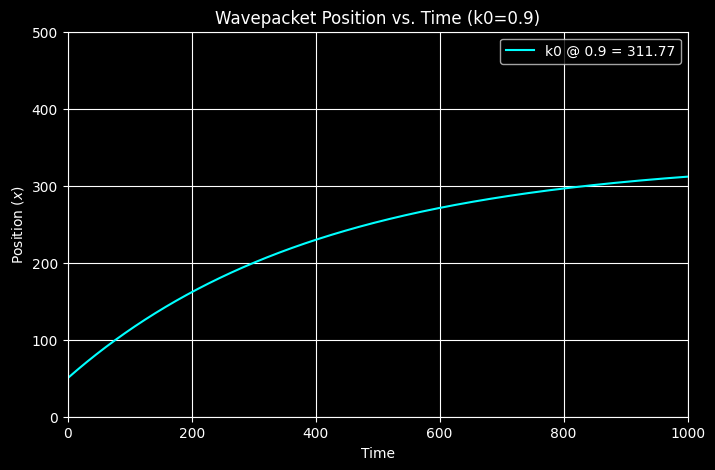

In [4]:
final_time = time_list[-1]
final_x_c = x_c_list[-1]

plt.figure(figsize=(8,5))
plt.plot(time_list, x_c_list, label=f'k0 @ {k0} = {final_x_c:.2f}', color='cyan')
plt.xlabel('Time')
plt.ylabel('Position $(x)$')
plt.xlim(0,frames*dt)
plt.ylim(0,500)
plt.grid(True)
plt.title(f'Wavepacket Position vs. Time (k0={k0})')
plt.legend()
plt.savefig(f"EFDM_2 @k0={k0}.png", dpi=600, bbox_inches='tight')
plt.show()